# k-Armed Bandit Problem

In this problem, our agent has to choose between `k` different actions (or arms) to maximize its reward. The agent does not know the expected rewards of each action, and it must explore to find out which action yields the highest reward.

For now, the model is unaware of its state, and the current action has no effect on the outcome of the next action. We will deal with the full reinforcement learning case later.

Let the value of an action be:
$$
q_*(a) = \mathbb{E}[R_t \mid A_t = a]
$$

In [1]:
## 10-armed bandit
import torch
import numpy as np

actions = list(range(0,9))
true_values = torch.randn(10)
def calculate_reward(action): return float(np.random.randn() + true_values[action])

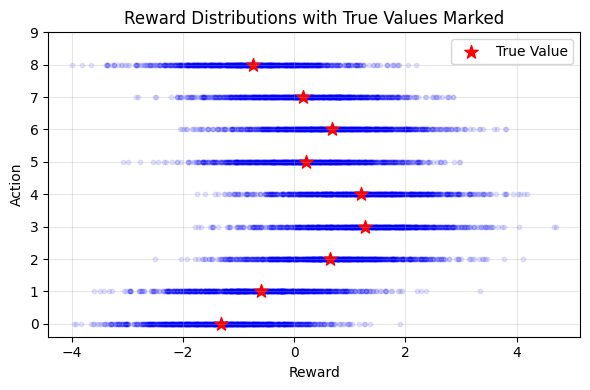

In [2]:
# Plot Reward Distribution for actions with true values marked

import matplotlib.pyplot as plt

# Plot reward distributions with true values marked
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# For each action, plot the reward distribution
for action in actions:
    rewards_for_action = [calculate_reward(action) for _ in range(1000)]
    
    # Create histogram for this action
    y_values = [action] * len(rewards_for_action)
    
    # Plot scatter points with alpha for density effect
    ax.scatter([r.item() if hasattr(r, 'item') else r for r in rewards_for_action], 
              y_values, alpha=0.1, s=10, color='blue')
    
    # Mark the true value with a red star
    ax.scatter(true_values[action].item(), action, 
              color='red', s=100, marker='*', 
              label='True Value' if action == 0 else "")

ax.set_ylabel('Action')
ax.set_xlabel('Reward')
ax.set_title('Reward Distributions with True Values Marked')
ax.set_yticks(range(len(true_values)))
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()


## Action-Value Methods
We make an estimation of the value of an action using this method. $q_*(a)$ is the actual expected reward of action $a$. The best estimated (or known) value of action $a$ is denoted as $Q_(a)$.

It is calculated as follows:
$$
Q_t(a) = \frac{\sum_{i=1}^{t-1} R_i \cdot \mathbb{I}(A_i = a)}{\sum_{i=1}^{t-1} \mathbb{I}(A_i = a)}
$$

Greedy decisions are made on this basis:
$$
A_t = \arg\max_a Q_t(a)
$$

Let's implement a 10-armed bandit problem with greedy decisions.

### Greedy Bandit

In [3]:
# Greedy Bandit Implementation

def greedy_bandit(iters):
    action_reward_pairs = [] # [[action_1, reward_1], ...]
    for i in range(iters):
        estimated_values = []
        for action in actions:
            estimated_value_numerator = sum([action_reward_pair[1] for action_reward_pair in action_reward_pairs if action_reward_pair[0] == action])
            estimated_value_denominator = sum([1 for action_reward_pair in action_reward_pairs if action_reward_pair[0] == action])
            estimated_value = (estimated_value_numerator / estimated_value_denominator) if estimated_value_denominator > 0 else 0
            estimated_values.append(estimated_value)

        selected_action = max(enumerate(estimated_values), key=lambda x: x[1])[0]
        reward_for_action = calculate_reward(selected_action)

        action_reward_pairs.append([selected_action, reward_for_action])

    return action_reward_pairs

### $\epsilon$-Greedy Bandit

In [4]:
# Epsilon-Greedy Bandit Implementation

def epsilon_greedy_bandit(iters, epsilon):
    action_reward_pairs = [] # [[action_1, reward_1], ...]
    for i in range(iters):
        estimated_values = []
        for action in actions:
            estimated_value_numerator = sum([action_reward_pair[1] for action_reward_pair in action_reward_pairs if action_reward_pair[0] == action])
            estimated_value_denominator = sum([1 for action_reward_pair in action_reward_pairs if action_reward_pair[0] == action])
            #print(action_reward_pairs)
            estimated_value = (estimated_value_numerator / estimated_value_denominator) if estimated_value_denominator > 0 else 0
            estimated_values.append(estimated_value)


        selected_action = max(enumerate(estimated_values), key=lambda x: x[1])[0] if np.random.rand() > epsilon else np.random.choice(actions)
        reward_for_action = calculate_reward(selected_action)

        action_reward_pairs.append([selected_action, reward_for_action])

    return action_reward_pairs


### $\epsilon$-Greedy Bandit with Incremental Action Value Update

In [5]:
# Epsilon-Greedy Bandit Implementation

def epsilon_greedy_bandit_incremental(iters, epsilon):
    action_reward_pairs = [] # [[action_1, reward_1], ...]
    action_reward_pairs_latest = [0] * len(actions)  # Initialize latest rewards for each action
    estimated_values = [0] * len(actions)  # Initialize estimated values for each action
    n_actions = [0] * len(actions)  # Initialize counts for each action
    for i in range(iters):
        for action in actions:
            n = n_actions[action]
            if n==0: n=1
            estimated_value = (estimated_values[action] + (1/(n)) * (action_reward_pairs_latest[action] - estimated_values[action])) 
            estimated_values[action] = estimated_value

        selected_action = max(enumerate(estimated_values), key=lambda x: x[1])[0] if np.random.rand() > epsilon else np.random.choice(actions)
        reward_for_action = calculate_reward(selected_action)

        action_reward_pairs.append([selected_action, reward_for_action])
        action_reward_pairs_latest[selected_action] = reward_for_action
        n_actions[selected_action] += 1

    return action_reward_pairs


### $\epsilon$-Greedy Bandit with $\alpha$-Incremental Action Value Update

In [6]:
# Epsilon-Greedy Bandit Implementation with Incremental Alpha

def epsilon_greedy_bandit_incremental_alpha(iters, epsilon, alpha):
    action_reward_pairs = [] # [[action_1, reward_1], ...]
    action_reward_pairs_latest = [0] * len(actions)  # Initialize latest rewards for each action
    estimated_values = [0] * len(actions)  # Initialize estimated values for each action
    for i in range(iters):
        for action in actions:
            estimated_value = (estimated_values[action] + alpha * (action_reward_pairs_latest[action] - estimated_values[action])) 
            estimated_values[action] = estimated_value

        selected_action = max(enumerate(estimated_values), key=lambda x: x[1])[0] if np.random.rand() > epsilon else np.random.choice(actions)
        reward_for_action = calculate_reward(selected_action)

        action_reward_pairs.append([selected_action, reward_for_action])
        action_reward_pairs_latest[selected_action] = reward_for_action

    return action_reward_pairs



### Upper Confidence Bound (UCB) Action Selection

$$
A_t = \arg\max_a \left( Q_t(a) + c \cdot \sqrt{\frac{\ln t}{N_t(a)}} \right)
$$

In [7]:
## Upper Confidence Bound (UCB) Bandit Implementation
def UCB(iters, epsilon, C):
    action_reward_pairs = [] # [[action_1, reward_1], ...]
    action_reward_pairs_latest = [0] * len(actions)  # Initialize latest rewards for each action
    estimated_values = [0] * len(actions)  # Initialize estimated values for each action
    n_actions = [0] * len(actions)  
    for i in range(iters):
        for action in actions:
            n = n_actions[action]
            if n == 0: n = 1  # Avoid division by zero
            estimated_value = (estimated_values[action] + (1/n) * (action_reward_pairs_latest[action] - estimated_values[action])) 
            estimated_values[action] = estimated_value

        #selected_action = max(enumerate(estimated_values), key=lambda x: x[1])[0] if np.random.rand() > epsilon else np.random.choice(actions)
        selected_action = max(enumerate(estimated_values), key=lambda x: x[1] + C * np.sqrt(np.log(i + 1) / ( 1 + sum([1 for action_reward_pair in action_reward_pairs if action_reward_pair[0] == x[0]]) )))[0] if np.random.rand() > epsilon else np.random.choice(actions)
        reward_for_action = calculate_reward(selected_action)

        action_reward_pairs.append([selected_action, reward_for_action])
        action_reward_pairs_latest[selected_action] = reward_for_action
        n_actions[selected_action] += 1

    return action_reward_pairs


## Gradient Bandit Algorithm

Instead of mapping value to action directly, we use $H_t(a)$, which is the preference of action $a$ at time $t$. The action is selected using a softmax distribution:
$$
Pr(A_t = a) = \frac{e^{H_t(a)}}{\sum_{b=1}^{k} e^{H_t(b)}} = \pi_t(a)
$$

In stochastic gradient ascent, we update the preferences as follows:
$$
H_{t+1}(a) = H_t(a) + \alpha \cdot \frac{\delta\mathbb{E}[R_t]}{\delta H_t(a)}
$$

Which simplifies to:
$$
H_{t+1}(A_t) = H_t(A_t) + \alpha \cdot (R_t - R_t^*) \cdot (1 - \pi_t(A_t)) \\
H_{t+1}(a) = H_t(a) - \alpha \cdot (R_t - R_t^*) \cdot \pi_t(a) \quad \text{for } a \neq A_t
$$

## Evaluating Methods


In [ ]:
# Method evaluation functions

def evaluate_method(method_function, iters, *args, smooth=True, method_iters = 100):
    total_rewards = [0] * iters
    all_action_reward_pairs = []  # Store all action-reward pairs for averaging
    for run in range(method_iters):
        action_reward_pairs = method_function(iters, *args)
        for i, (_, reward) in enumerate(action_reward_pairs):
            total_rewards[i] += reward

        all_action_reward_pairs.append(action_reward_pairs)
            
    average_rewards = [total / method_iters for total in total_rewards]

    # Optimal action percentage calculation
    optimal_action = max(enumerate(true_values), key=lambda x: x[1])[0]
    optimal_action_percentage = [0] * iters
    for action_reward_pairs in all_action_reward_pairs:
        current_iter = -1
        for action, reward in action_reward_pairs:
            current_iter += 1
            if action == optimal_action:
                optimal_action_percentage[current_iter] += 1

    optimal_action_percentage = [(count / method_iters * 100) for count in optimal_action_percentage]
    
    # Smooth the average rewards using a rolling average with 10 neighbors
    smoothed_rewards = []
    window_size = 50
    for i in range(len(average_rewards)):
        start_idx = max(0, i - window_size // 2)
        end_idx = min(len(average_rewards), i + window_size // 2 + 1)
        window_avg = sum(average_rewards[start_idx:end_idx]) / (end_idx - start_idx)
        smoothed_rewards.append(window_avg)
    
    # Smooth the optimal action percentage using a rolling average with same window size
    smoothed_optimal_action_percentage = []
    for i in range(len(optimal_action_percentage)):
        start_idx = max(0, i - window_size // 2)
        end_idx = min(len(optimal_action_percentage), i + window_size // 2 + 1)
        window_avg = sum(optimal_action_percentage[start_idx:end_idx]) / (end_idx - start_idx)
        smoothed_optimal_action_percentage.append(window_avg)


    if smooth: return smoothed_rewards, smoothed_optimal_action_percentage
    else: return average_rewards, optimal_action_percentage

def plot_results(method_name_list, average_rewards_list, optimal_action_percentage_list):
    # Plot 1 - Average Rewards
    
    plt.figure(figsize=(8, 5))
    for method_name, average_rewards in zip(method_name_list, average_rewards_list):
        plt.plot(average_rewards, label=method_name, linewidth=2)
    
    plt.xlabel('Iterations')
    plt.ylabel('Average Reward')
    plt.title('Comparison of Bandit Methods: Average Rewards')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot 2 - Optimal Action Percentage
    plt.figure(figsize=(8, 5))
    for method_name, optimal_action_percentage in zip(method_name_list, optimal_action_percentage_list):
        plt.plot(optimal_action_percentage, label=method_name, linewidth=2)
    
    plt.xlabel('Iterations')
    plt.ylabel('Optimal Action Percentage')
    plt.title('Comparison: Optimal Action Selection Percentage')
    plt.legend()
    plt.grid(True)
    plt.show()
        

    return None

In [ ]:
iters = 1000
epsilon = 0.1
alpha = 0.1
c = 2

method_name_list = [
    "Greedy Bandit",
    "Epsilon-Greedy Bandit",
    "Epsilon-Greedy Bandit Incremental",
    "Epsilon-Greedy Bandit Incremental Alpha",
    "UCB Bandit"
]

method_list = [
    ["Greedy Bandit", greedy_bandit, iters],
    ["Epsilon-Greedy Bandit", epsilon_greedy_bandit, iters, epsilon],
    ["Epsilon-Greedy Bandit Incremental", epsilon_greedy_bandit_incremental, iters, epsilon],
    ["Epsilon-Greedy Bandit Incremental Alpha", epsilon_greedy_bandit_incremental_alpha, iters, epsilon, alpha],
    ["UCB Bandit", UCB, iters, epsilon, c]
]

all_average_rewards = []
all_optimal_action_percentages = []

for method in method_list:
    average_rewards, optimal_action_percentage = evaluate_method(method[1], method[2], *method[3:], smooth=True, method_iters=100)
    print("Calculated average rewards for method:", method[0])
    all_average_rewards.append(average_rewards)
    all_optimal_action_percentages.append(optimal_action_percentage)
    
    
    
plot_results(method_name_list, all_average_rewards, all_optimal_action_percentages)